In [0]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from PIL import Image
import tensorflow as tf

In [2]:
!pip install tqdm
from tqdm import tqdm
tf.set_random_seed(10)
np.random.seed(10)

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://github.com/harveenchadha/dump-nn-tf/raw/master/Section2/NN_Predict_Fraud/train.csv')
df.head()
df.dropna(inplace=True)
x = df.iloc[:, :30]
y = df.iloc[:, -1:]

scl = StandardScaler()
x = scl.fit_transform(x)

In [0]:
def WeightsVariable(shape, name = 'weights'):
    return tf.Variable(tf.truncated_normal(shape, mean = 0.0, stddev=0.001, name=name))

def BiasVariable(shape, name = 'biases'):
    return tf.Variable(tf.constant(1.0, shape=[shape], name='biases'))

In [0]:
def network(images, channels = 1):
    num_c = [128, 64, 64, 64, 32, 128]

    with tf.name_scope('fc1'):
        weights = WeightsVariable([30, num_c[0]])
        biases = BiasVariable(num_c[0])
        fc1 = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    with tf.name_scope('fc2'):
        weights = WeightsVariable([num_c[0], num_c[1]])
        biases = BiasVariable(num_c[1])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc3'):
        weights = WeightsVariable([num_c[1], num_c[2]])
        biases = BiasVariable(num_c[2])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc5'):
        weights = WeightsVariable([num_c[2], num_c[3]])
        biases = BiasVariable(num_c[3])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)
        
    with tf.name_scope('fc6'):
        weights = WeightsVariable([num_c[3], num_c[4]])
        biases = BiasVariable(num_c[4])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights) + biases)   

    with tf.name_scope('fc4'):
        weights = WeightsVariable([num_c[4], 1])
        biases = BiasVariable(1)
        fc2 = tf.matmul(fc1, weights) + biases
    return fc2

In [0]:
def loss_metrics(logits, labels):
    logits = logits
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, 
                                                                   logits = logits, 
                                                                   name = 'softmax')
    return tf.reduce_mean(cross_entropy, name = 'softmax_mean')

In [0]:
#returns the optimizer by taking the loss
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate = STARTER_LR)
    train_op = optimizer.minimize(loss)
    return train_op
    

In [0]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, k = 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))#, accuracy1, accuracy2
  
def acc(logits, labels):
    correct_prediction = tf.equal(tf.cast(tf.greater_equal(logits,0.5), tf.float32) , labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    return accuracy

In [0]:
def placeholder_inputs(batch_size, shape = [30]):
    image_placeholder = tf.placeholder(tf.float32, shape = (None, shape[0]))
    label_placeholder = tf.placeholder(tf.float32, shape = (None))
    return image_placeholder, label_placeholder

In [0]:

loss_plot = []
acc_plot = []
train_plot = []
def run_training(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    with tf.Graph().as_default():

        images_pl, labels_pl = placeholder_inputs(BATCH_SIZE)
        logits = network(images_pl)
        print("Logits Calculated Successfully")
        loss = loss_metrics(logits = logits, labels = labels_pl)
        train_op = training(loss)
#         eval_correct = evaluation(logits, labels_pl)
        acc_val = acc(logits, labels_pl)
        summary = tf.summary.merge_all()
        
        init = tf.global_variables_initializer()
        
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) #OPTIONAL
        sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))
        
        saver = tf.train.Saver()
        sess.run(init)
        for steps in range(MAX_STEPS):
            loss_avg = []
            for i in tqdm(np.arange(0, len(x_train), BATCH_SIZE)):
                images_feed = x_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]
                labels_feed = y_train[i*BATCH_SIZE:i*(BATCH_SIZE+1)]

                feed_dict = { images_pl: np.reshape(images_feed, (-1, 30)), labels_pl: labels_feed }

                _ = sess.run([train_op], feed_dict = feed_dict)
                

            images_feed = x_test
            labels_feed = y_test

            feed_dict = {
                images_pl: np.reshape(images_feed, (-1, 30)),
                labels_pl: labels_feed
                        }
            loss_  = sess.run([loss], feed_dict = feed_dict)
            accuracy_val  = sess.run([acc_val], feed_dict = feed_dict)
            
            images_feed = x_train
            labels_feed = y_train

            feed_dict = {
                images_pl: np.reshape(images_feed, (-1, 30)),
                labels_pl: labels_feed
                        }
            train_loss  = sess.run([loss], feed_dict = feed_dict)
            
            loss_plot.append(loss_)
            train_plot.append(train_loss)
            acc_plot.append(accuracy_val)
            print('\t Loss %d: Training loss = %.5f  Validation loss = %.5f\t Validation Acc = %.5f' % (steps+1, train_loss[0], loss_[0], accuracy_val[0]))     
          
        return sess, images_pl, labels_pl, acc_val, logits

In [113]:
STARTER_LR = 6e-5
BATCH_SIZE = 4
NUM_CLASSES = 10
MAX_STEPS = 100

loss_plot = []
acc_plot = []
train_plot = []
sess, images_pl, labels_pl, eval_correct, logits = run_training(np.asarray(x, dtype = np.float32), np.asarray(y, dtype = np.int32))

Logits Calculated Successfully


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 1: Training loss = 0.77248  Validation loss = 0.85259	 Validation Acc = 0.42778
	 Loss 2: Training loss = 0.70806  Validation loss = 0.74911	 Validation Acc = 0.57222


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 3: Training loss = 0.69625  Validation loss = 0.73223	 Validation Acc = 0.57222
	 Loss 4: Training loss = 0.67949  Validation loss = 0.70796	 Validation Acc = 0.57222


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 5: Training loss = 0.66769  Validation loss = 0.69450	 Validation Acc = 0.66667
	 Loss 6: Training loss = 0.65842  Validation loss = 0.68492	 Validation Acc = 0.68333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 7: Training loss = 0.64855  Validation loss = 0.67433	 Validation Acc = 0.70556
	 Loss 8: Training loss = 0.63825  Validation loss = 0.66301	 Validation Acc = 0.71667


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 9: Training loss = 0.62788  Validation loss = 0.65134	 Validation Acc = 0.72778
	 Loss 10: Training loss = 0.61717  Validation loss = 0.63886	 Validation Acc = 0.73333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 11: Training loss = 0.60669  Validation loss = 0.62639	 Validation Acc = 0.76111
	 Loss 12: Training loss = 0.59590  Validation loss = 0.61331	 Validation Acc = 0.78333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 13: Training loss = 0.58495  Validation loss = 0.59984	 Validation Acc = 0.78889
	 Loss 14: Training loss = 0.57414  Validation loss = 0.58652	 Validation Acc = 0.78889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 15: Training loss = 0.56371  Validation loss = 0.57364	 Validation Acc = 0.79444
	 Loss 16: Training loss = 0.55399  Validation loss = 0.56174	 Validation Acc = 0.79444


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 17: Training loss = 0.54430  Validation loss = 0.54975	 Validation Acc = 0.80000
	 Loss 18: Training loss = 0.53527  Validation loss = 0.53875	 Validation Acc = 0.80556


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 19: Training loss = 0.52636  Validation loss = 0.52788	 Validation Acc = 0.80556
	 Loss 20: Training loss = 0.51792  Validation loss = 0.51761	 Validation Acc = 0.80556


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 21: Training loss = 0.50945  Validation loss = 0.50719	 Validation Acc = 0.81667
	 Loss 22: Training loss = 0.50394  Validation loss = 0.50123	 Validation Acc = 0.82778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 23: Training loss = 0.49452  Validation loss = 0.48926	 Validation Acc = 0.82778
	 Loss 24: Training loss = 0.48493  Validation loss = 0.47711	 Validation Acc = 0.82778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 25: Training loss = 0.47622  Validation loss = 0.46624	 Validation Acc = 0.82778
	 Loss 26: Training loss = 0.46733  Validation loss = 0.45525	 Validation Acc = 0.82778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 27: Training loss = 0.46028  Validation loss = 0.44726	 Validation Acc = 0.84444
	 Loss 28: Training loss = 0.45238  Validation loss = 0.43799	 Validation Acc = 0.84444


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 29: Training loss = 0.44311  Validation loss = 0.42636	 Validation Acc = 0.84444
	 Loss 30: Training loss = 0.44058  Validation loss = 0.42577	 Validation Acc = 0.85000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 31: Training loss = 0.43349  Validation loss = 0.41775	 Validation Acc = 0.86111
	 Loss 32: Training loss = 0.41646  Validation loss = 0.39322	 Validation Acc = 0.85000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 33: Training loss = 0.40908  Validation loss = 0.38491	 Validation Acc = 0.85556
	 Loss 34: Training loss = 0.39272  Validation loss = 0.35880	 Validation Acc = 0.85000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 35: Training loss = 0.38448  Validation loss = 0.33231	 Validation Acc = 0.83333
	 Loss 36: Training loss = 0.38593  Validation loss = 0.32714	 Validation Acc = 0.82778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 37: Training loss = 0.38367  Validation loss = 0.31988	 Validation Acc = 0.82778
	 Loss 38: Training loss = 0.37791  Validation loss = 0.31308	 Validation Acc = 0.83889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 39: Training loss = 0.37649  Validation loss = 0.30882	 Validation Acc = 0.83889
	 Loss 40: Training loss = 0.37255  Validation loss = 0.30444	 Validation Acc = 0.84444


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 41: Training loss = 0.36839  Validation loss = 0.29979	 Validation Acc = 0.84444
	 Loss 42: Training loss = 0.36682  Validation loss = 0.29531	 Validation Acc = 0.85556


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 43: Training loss = 0.36003  Validation loss = 0.28869	 Validation Acc = 0.85556
	 Loss 44: Training loss = 0.35810  Validation loss = 0.28677	 Validation Acc = 0.85556


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 45: Training loss = 0.35161  Validation loss = 0.27989	 Validation Acc = 0.87222
	 Loss 46: Training loss = 0.35307  Validation loss = 0.27917	 Validation Acc = 0.87222


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 47: Training loss = 0.34631  Validation loss = 0.27274	 Validation Acc = 0.88333
	 Loss 48: Training loss = 0.34089  Validation loss = 0.26772	 Validation Acc = 0.88889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 49: Training loss = 0.34000  Validation loss = 0.26482	 Validation Acc = 0.88889
	 Loss 50: Training loss = 0.33099  Validation loss = 0.25820	 Validation Acc = 0.88889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 51: Training loss = 0.33512  Validation loss = 0.25888	 Validation Acc = 0.88889
	 Loss 52: Training loss = 0.31465  Validation loss = 0.24610	 Validation Acc = 0.90000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 53: Training loss = 0.32416  Validation loss = 0.25012	 Validation Acc = 0.88889
	 Loss 54: Training loss = 0.31238  Validation loss = 0.24067	 Validation Acc = 0.90000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 55: Training loss = 0.31605  Validation loss = 0.24216	 Validation Acc = 0.90000
	 Loss 56: Training loss = 0.30723  Validation loss = 0.23482	 Validation Acc = 0.90000


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 57: Training loss = 0.30796  Validation loss = 0.23440	 Validation Acc = 0.90000
	 Loss 58: Training loss = 0.30128  Validation loss = 0.22901	 Validation Acc = 0.90556


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 59: Training loss = 0.29962  Validation loss = 0.22696	 Validation Acc = 0.91111
	 Loss 60: Training loss = 0.29450  Validation loss = 0.22242	 Validation Acc = 0.91667


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 61: Training loss = 0.29152  Validation loss = 0.21927	 Validation Acc = 0.91667
	 Loss 62: Training loss = 0.28538  Validation loss = 0.21426	 Validation Acc = 0.92222


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 63: Training loss = 0.28598  Validation loss = 0.21337	 Validation Acc = 0.92222
	 Loss 64: Training loss = 0.27926  Validation loss = 0.20771	 Validation Acc = 0.92778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 65: Training loss = 0.27696  Validation loss = 0.20521	 Validation Acc = 0.92778
	 Loss 66: Training loss = 0.27057  Validation loss = 0.20005	 Validation Acc = 0.92778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 67: Training loss = 0.27302  Validation loss = 0.20064	 Validation Acc = 0.92778
	 Loss 68: Training loss = 0.26733  Validation loss = 0.19545	 Validation Acc = 0.92778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 69: Training loss = 0.26308  Validation loss = 0.19158	 Validation Acc = 0.92778
	 Loss 70: Training loss = 0.26069  Validation loss = 0.18916	 Validation Acc = 0.92778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 71: Training loss = 0.25726  Validation loss = 0.18603	 Validation Acc = 0.92778
	 Loss 72: Training loss = 0.25444  Validation loss = 0.18338	 Validation Acc = 0.92778


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 73: Training loss = 0.25008  Validation loss = 0.17955	 Validation Acc = 0.92778
	 Loss 74: Training loss = 0.24752  Validation loss = 0.17715	 Validation Acc = 0.93333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 75: Training loss = 0.24405  Validation loss = 0.17392	 Validation Acc = 0.93333
	 Loss 76: Training loss = 0.24340  Validation loss = 0.17299	 Validation Acc = 0.93333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 77: Training loss = 0.23918  Validation loss = 0.16909	 Validation Acc = 0.93333
	 Loss 78: Training loss = 0.23791  Validation loss = 0.16770	 Validation Acc = 0.93333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 79: Training loss = 0.23432  Validation loss = 0.16427	 Validation Acc = 0.93333
	 Loss 80: Training loss = 0.23407  Validation loss = 0.16381	 Validation Acc = 0.93333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 81: Training loss = 0.22840  Validation loss = 0.15876	 Validation Acc = 0.93333
	 Loss 82: Training loss = 0.23179  Validation loss = 0.16118	 Validation Acc = 0.93333


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 83: Training loss = 0.22490  Validation loss = 0.15505	 Validation Acc = 0.93333
	 Loss 84: Training loss = 0.22625  Validation loss = 0.15587	 Validation Acc = 0.93889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 85: Training loss = 0.22155  Validation loss = 0.15168	 Validation Acc = 0.93889
	 Loss 86: Training loss = 0.22324  Validation loss = 0.15259	 Validation Acc = 0.93889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 87: Training loss = 0.21406  Validation loss = 0.14504	 Validation Acc = 0.93889
	 Loss 88: Training loss = 0.22171  Validation loss = 0.15083	 Validation Acc = 0.93889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 89: Training loss = 0.21157  Validation loss = 0.14287	 Validation Acc = 0.93889
	 Loss 90: Training loss = 0.21242  Validation loss = 0.14306	 Validation Acc = 0.93889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 91: Training loss = 0.20495  Validation loss = 0.13743	 Validation Acc = 0.94444
	 Loss 92: Training loss = 0.21151  Validation loss = 0.14181	 Validation Acc = 0.93889


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 93: Training loss = 0.20080  Validation loss = 0.13381	 Validation Acc = 0.94444
	 Loss 94: Training loss = 0.20427  Validation loss = 0.13618	 Validation Acc = 0.94444


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 95: Training loss = 0.19543  Validation loss = 0.13002	 Validation Acc = 0.94444
	 Loss 96: Training loss = 0.20032  Validation loss = 0.13258	 Validation Acc = 0.94444


  0%|          | 0/180 [00:00<?, ?it/s]

	 Loss 97: Training loss = 0.19725  Validation loss = 0.13017	 Validation Acc = 0.94444
	 Loss 98: Training loss = 0.19074  Validation loss = 0.12558	 Validation Acc = 0.95000


100%|██████████| 180/180 [00:00<00:00, 1262.11it/s]


	 Loss 99: Training loss = 0.19859  Validation loss = 0.13037	 Validation Acc = 0.95000
	 Loss 100: Training loss = 0.18967  Validation loss = 0.12415	 Validation Acc = 0.95000


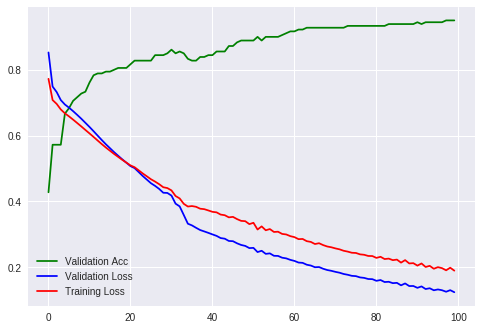

In [136]:
sns.set_style("darkgrid")
plt.plot(acc_plot,'g-',label="Validation Acc")
plt.plot(loss_plot, 'b-', label="Validation Loss")
plt.plot(train_plot, "r-", label='Training Loss')
plt.legend(loc='best')

In [0]:
images_feed, labels_feed = MNIST_DATASETS.validation.images, MNIST_DATASETS.validation.labels

feed_dict = {
    images_pl: np.reshape(images_feed, (-1, 28, 28, 1))
            }
with sess.as_default():
  accuracy  = sess.run([logits], feed_dict = feed_dict)
  
  preds = np.argmax(accuracy[0], 1)
  print(preds)

[5 0 4 ... 2 1 2]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(labels_feed, preds))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       479
          1       0.97      0.98      0.97       563
          2       0.98      0.93      0.96       488
          3       0.98      0.96      0.97       493
          4       0.98      0.98      0.98       535
          5       0.96      0.98      0.97       434
          6       0.98      0.98      0.98       501
          7       0.96      0.97      0.97       550
          8       0.96      0.97      0.97       462
          9       0.96      0.96      0.96       495

avg / total       0.97      0.97      0.97      5000



In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_feed, preds))

[[473   0   0   0   0   2   2   0   0   2]
 [  0 553   2   2   1   0   1   2   2   0]
 [  1  10 454   5   1   1   0   7   8   1]
 [  0   1   2 475   0   7   0   5   2   1]
 [  0   1   0   0 526   0   4   1   0   3]
 [  0   1   1   0   1 427   0   0   3   1]
 [  3   2   0   0   1   1 493   0   1   0]
 [  0   2   2   1   3   0   0 536   0   6]
 [  0   2   0   1   0   3   1   2 449   4]
 [  2   1   0   2   5   2   0   7   2 474]]


In [0]:
# graph = tf.GraphDef()
# graph.ParseFromString(tf_model.SerializeToString())

# with tf.Graph().as_default() as graph:
#         # The name var will prefix every op/nodes in your graph
#         # Since we load everything in a new graph, this is not needed
#     tf.import_graph_def(graph, name="prefix")
    
    